# KAN: Kolmogorov–Arnold Networksを用いたmass model

中国のグループによって、KANによる原子核のmass modelが提唱された: [arXiv:2407.20737v1](https://arxiv.org/abs/2407.20737)

KANはその性質からシンボリック回帰が行いやすく、反応模型(光学ポテンシャルなど)とも親和性が高いと思われる。

In [1]:
import torch

## KANの式

$$
f(\mathbf{x}) = f(x_1, \cdots, x_d) = \sum^{2d+1}_{q=1} \Phi_q \left( \sum^d_{p=1} \phi_{q,p} (x_p) \right)
$$


## データの準備

データとして、上記の論文と同様、Atomic Mass Evaluation (AME)の2020版を用いる。
AMEの野良パッケージもありそうだが、NuclearToolkit.jl内の関連する部分を流用する力技で対処する。

Julia言語の自作structの辞書になっている。これを変換&少し整形する。

In [2]:
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as coll
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def get_amedata_in_myPkg():
    # BE, BEerr, BETF(False means estimatino by AME2020), Sn, Snerr, Qval, Qerr
    # → Nuc, Z, N, BE(MeV), BEerr(MeV), BETF, Sn(MeV), SnTF, Snerr(MeV), SnerrTF, Qval(MeV), QvalTF, Qerr(MeV), QerrTFとDataFrame化する
    url = "https://raw.githubusercontent.com/SotaYoshida/NuclearToolkit.jl/main/src/NuclData.jl/amedata.jl"
    with urllib.request.urlopen(url) as f:     
        lines = f.read().decode('cp932').split('\n')
    hit = 0
    array = [ ]
    for line in lines:
        if "ame2020data = Dict(" in line:
            hit = 1
            continue
        if hit == 0:
            continue
        if line.strip() == ")":
            break
        tmp = line.replace('"',"").split(",  ")
        key_nuc = tmp[0].split("=>")[0]
        keyZN = map(int, tmp[1].split("=>")[0].replace("[","").replace("]","").split(","))
        Z, N = keyZN
        A = Z + N 
        data = tmp[0].split("AMEdata(")[-1].replace(")","").split(",")
        data = data[0:4] + [False] + [data[4]] + [False] + [data[5]] + [False] + [data[6]] + [False]
        idxs = [0, 1, 2, 3, 5, 7, 9]
        for idx in idxs:
            tmp = data[idx]
            if idx == 2: # for rewriting BETF
                if data[idx] == "true":
                    data[idx] = True
                elif data[idx] == "false":
                    data[idx] = False
                else:
                    print("This should not happen:", tmp, "idx=",idx)
                continue
            if tmp == "" or tmp == "*":
                data[idx] = float('nan')
            elif "#" in tmp:
                data[idx] = float(data[idx].replace("#",""))
                data[idx] += 1
            else:
                data[idx] = float(data[idx])
            if idx in [0, 1, 3, 5, 7, 9]:
                data[idx] /= 10**3
                if idx in [0, 1]:
                    data[idx] *= A
        row = [key_nuc, Z, N] + data
        array += [ row ]
    df = pd.DataFrame(array, columns=["Nuc", "Z", "N", "BE(MeV)", "BEerr(MeV)", "BETF", "Sn(MeV)", "SnTF", "Snerr(MeV)", "SnerrTF", "Qval(MeV)", "QvalTF", "Qerr(MeV)", "QerrTF"])
    return df 

def add_more_info(df):
    #A, N-Z, A^(2/3), Z_EO, N_EO, Zm, Nm, Zshell, Nshellなどの情報を付加
    df["A"] = df["N"] + df["Z"]
    df["N-Z"] = df["N"]- df["Z"]    
    df["A^(2/3)"] = df["A"]**(2/3)
    df["Z_EO"] = df["Z"] % 2
    df["N_EO"] = df["N"] % 2
    ref_magic = np.array([0, 8, 20, 28, 50, 82, 126, 184])
    Zm = [ ]; Nm = [ ]
    ref_shell = np.array([0, 29,  51, 83, 127])
    Zsh = [ ]; Nsh = [ ]
    for idx in range(df.shape[0]):
        Z = df.loc[idx,"Z"]
        N = df.loc[idx,"N"]
        Zsub = Z - ref_magic
        Nsub = N - ref_magic
        Zres = np.min( Zsub[ Zsub >= 0 ] )
        Nres = np.min( Nsub[ Nsub >= 0 ] )
        if not(Z-Zres in ref_magic) or not(N-Nres in ref_magic):
            print(Z, N, Zres, Nres, "Zsub", Zsub)
            raise ValueError("something wrong for Zm/Nm")
        Zm += [Zres]
        Nm += [Nres]
        tZs = tNs = 4
        for ishell in range(len(ref_shell)):
            if Z >= ref_shell[ishell]:
                tZs = ishell
            if N >= ref_shell[ishell]:
                tNs = ishell
        Zsh += [tZs]
        Nsh += [tNs]
    df["Zm"] = Zm; df["Nm"] = Nm
    df["Zshell"] = Zsh; df["Nshell"] = Nsh
    
df = get_amedata_in_myPkg()
add_more_info(df)
display(df)

,Nuc,Z,N,BE(MeV),BEerr(MeV),BETF,Sn(MeV),SnTF,Snerr(MeV),SnerrTF,...,QerrTF,A,N-Z,A^(2/3),Z_EO,N_EO,Zm,Nm,Zshell,Nshell
0,n1,0,1,0.000000,0.000000e+00,True,0.000000,False,0.000000e+00,False,...,False,1,1,1.000000,0,1,0,1,0,0
1,H1,1,0,0.000000,0.000000e+00,True,NaN,False,NaN,False,...,False,1,-1,1.000000,1,0,1,0,0,0
2,H2,1,1,2.224566,4.000000e-07,True,2.224566,False,4.000000e-07,False,...,False,2,0,1.587401,1,1,1,1,0,0
3,H3,1,2,8.481796,9.000000e-07,True,6.257230,False,4.000000e-07,False,...,False,3,1,2.080084,1,0,1,2,0,0
4,He3,2,1,7.718041,4.500000e-07,True,NaN,False,NaN,False,...,False,3,-1,2.080084,0,1,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,Ts293,117,176,2078.835000,8.790000e-01,False,7.265000,False,1.027000e+00,False,...,False,293,59,44.114201,1,0,35,50,3,4
3554,Og293,118,175,2073.854000,5.860000e-01,False,NaN,False,NaN,False,...,False,293,57,44.114201,0,1,36,49,3,4
3555,Ts294,117,177,2085.048000,5.880000e-01,False,6.104000,False,9.790000e-01,False,...,False,294,60,44.214517,1,1,35,51,3,4
3556,Og294,118,176,2081.226000,5.880000e-01,False,7.554000,False,9.000000e-01,False,...,False,294,58,44.214517,0,0,36,50,3,4


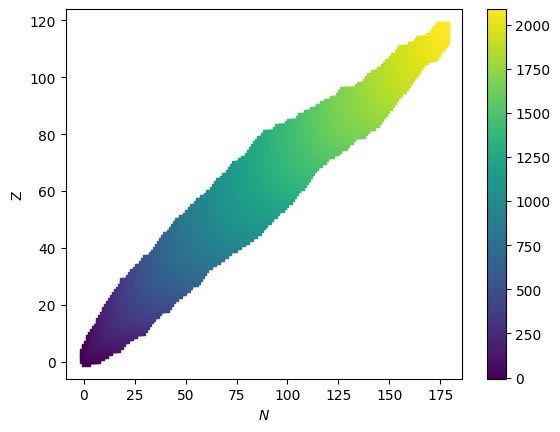

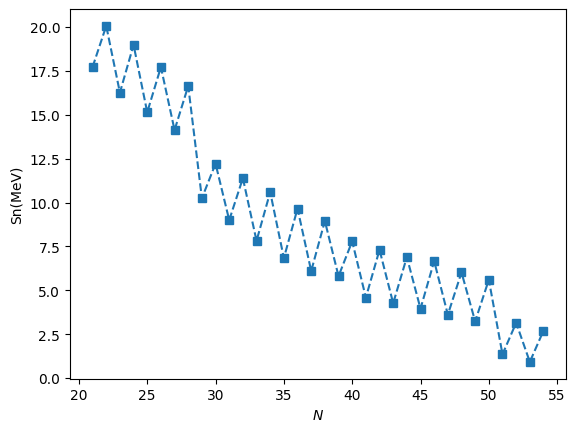

In [3]:
def plot_chart(df, item):
    z = df[item].values
    x = df["N"].values
    y = df["Z"].values
    fig = plt.figure()
    ax = plt.subplot(1,1,1); ax.set_xlabel("$N$"); ax.set_ylabel("Z")
    im = ax.scatter(x, y, marker="s", c=z)
    fig.colorbar(im)
    plt.show()
    plt.close()

def plot_item_for_isotopes(df, item, Z):
    subdf = df[ df["Z"] == Z ]
    y = subdf[item].values
    x = subdf["N"].values
    fig = plt.figure()
    ax = plt.subplot(1,1,1); ax.set_xlabel("$N$"); ax.set_ylabel(item)
    ax.plot(x, y, marker="s", ls="dashed")
    plt.show()
    plt.close()

item = "BE(MeV)"
plot_chart(df, item)

item = "Sn(MeV)"
plot_item_for_isotopes(df, item, 28)

論文では、以下の表のように4つのモデルと特徴量を考えている:

| Model | Features |
| ---- | ---- |
| KAN-2| $N, Z$|
| KAN-4| $N, Z, A, N-Z$|
| KAN-9| $N, Z, A, N-Z, A^{2/3}, Z_\mathrm{EO}, N_\mathrm{EO}, Z_\mathrm{m}, N_\mathrm{m}$|
| KAN-11|$N, Z,A, N-Z, A^{2/3}, Z_\mathrm{EO}, N_\mathrm{EO}, Z_\mathrm{m}, N_\mathrm{m}, Z_\mathrm{shell}, N_\mathrm{shell}$|



## Loss function

論文で用いられている誤差関数は、L1正則化と交差エントロピーを有した形:

$$
\mathcal{L} = \frac{ (\mathrm{BE}_\mathrm{pred}-\mathrm{BE}_\mathrm{exp})^2}{N_p} + \lambda \left(  \mu_1 \sum^{L-1}_{l=0} ||\Phi_l||_1 + \mu_2 \sum^{L-1}_{l=0} S(\Phi_l) \right)
$$

$N_p$は入力(prediction data)の数、$L$はlayerの数、$l$は$l$番目のレイヤーを意味する。

L1 norm:

$$
||\phi||_1 \equiv \frac{1}{N_p}\sum^{N_p}_{s=1} | \phi(x^{(s)}) | \\
||\Phi||_1 \equiv \sum^{n_\mathrm{in}}_{i=1} \sum^{n_\mathrm{out}}_{j=1} || \phi_{i,j} ||_1
$$

cross entropy:

$$
S(\Phi) \equiv - \sum^{n_\mathrm{in}}_{i=1} \sum^{n_\mathrm{out}}_{j=1} \frac{||\phi_{i,j}||_1}{||\Phi||_1} \log \frac{||\phi_{i,j}||_1}{||\Phi||_1} 
$$

論文でどうしているかは書かれていないが、KANの論文には通常(特に理由がなければという意味だと思うが)$\mu_1 =\mu_2$にすると書いてある。
また、$\lambda$についても$10^{-2}$とか$10^{-3}$と書かれてあるのでこのあたりを使ってみることにしよう。

## データセットの作成

上で作ったDataFrameから、データセットを作成する。

モデルごとに特徴量が異なるので、それに合わせてデータセットを作成する関数を作っておく。

In [4]:
features = {2: ["Z", "N"], 
            4: ["Z", "N", "A", "N-Z"],
            9: ["Z", "N", "A", "N-Z", "A^(2/3)", "Z_EO", "N_EO", "Zm", "Nm"],
            11: ["Z", "N", "A", "N-Z", "A^(2/3)", "Z_EO", "N_EO", "Zm", "Nm", "Zshell", "Nshell"]}

def extract_data_for_model(df, model_feature, item="BE(MeV)", Zmin=8, Nmin=8, Zmax=500, Nmax=500):    
    subdf = df[ (df["Z"] >= Zmin) & (df["Z"] <= Zmax ) & (df["N"] >= Nmin) & (df["N"] <= Nmax) ][features[model_feature]+[item]]
    print(subdf.shape)
    return subdf

model_feature = 11
subdata = extract_data_for_model(df, model_feature, item="BE(MeV)") # to be data of 3456 nuclei
subdata

(3456, 12)


,Z,N,A,N-Z,A^(2/3),Z_EO,N_EO,Zm,Nm,Zshell,Nshell,BE(MeV)
75,8,8,16,0,6.349604,0,0,0,0,0,0,127.619315
81,8,9,17,1,6.611489,0,1,0,1,0,0,131.762395
82,9,8,17,-1,6.611489,1,0,1,0,0,0,128.219583
88,8,10,18,2,6.868285,0,0,0,2,0,0,139.807766
89,9,9,18,0,6.868285,1,1,1,1,0,0,137.369489
...,...,...,...,...,...,...,...,...,...,...,...,...
3553,117,176,293,59,44.114201,1,0,35,50,3,4,2078.835000
3554,118,175,293,57,44.114201,0,1,36,49,3,4,2073.854000
3555,117,177,294,60,44.214517,1,1,35,51,3,4,2085.048000
3556,118,176,294,58,44.214517,0,0,36,50,3,4,2081.226000


論文では、3つのデータセットに分けてcross validationを行っているが、ここでは1つのデータセットにまとめてしまう。

In [5]:
def make_batch_data(dataset, k=3, verbose=True):
    subidxs = np.array_split(np.random.permutation(dataset.shape[0]), k)
    X, Y = [ ], [ ]
    if verbose:
        print(subidxs)
    for batch in range(k):
        if verbose:
            print("batch=",batch, "shape", dataset.iloc[subidxs[batch],0:-1].values.shape)
        X += [ dataset.iloc[subidxs[batch],0:-1].values ]
        Y += [ dataset.iloc[subidxs[batch],[-1]].values ]
    return X, Y

def create_dataset_AME(subdata, rate_train=0.7, verbose=True, normalize_input=True, normalize_label=True, device='cpu', seed=0):
    '''
    create dataset
    
    Args:
    -----
        rate_train: float
            the ratio of training data. Default: 0.7.

        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.
        
    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
         
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    NumD = subdata.shape[0]
    idxs = np.random.permutation(NumD)
    train_idxs = idxs[0:int(NumD*rate_train)]
    test_idxs = idxs[int(NumD*rate_train):]
    
    train_num = len(train_idxs)
    test_num = len(test_idxs)
    n_var = subdata.shape[1] - 1

    # X: features
    train_input = torch.tensor(subdata.iloc[train_idxs,0:-1].values, dtype=torch.float32)
    test_input = torch.tensor(subdata.iloc[test_idxs,0:-1].values, dtype=torch.float32)

    # Y: target
    train_label = torch.tensor(subdata.iloc[train_idxs,[-1]].values, dtype=torch.float32) 
    test_label = torch.tensor(subdata.iloc[test_idxs,[-1]].values, dtype=torch.float32)
                
    def normalize(data, mean, std):
            return (data-mean)/std
            
    if normalize_input == True:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)
        
    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)

    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset, mean_input, std_input, mean_label, std_label

def inverse_normalize(data, mean, std):
    return data*std + mean

dataset, mean_input, std_input, mean_label, std_label = create_dataset_AME(subdata)

## モデルの構築

KANの構築や学習は[pykan](https://github.com/KindXiaoming/pykan)及び[efficient-KAN](https://github.com/Blealtan/efficient-kan)に倣う。

前者はKAN論文の著者によるもので、後者はPyTorchを用いたより効率的な実装である。

In [ ]:
model_feature

In [16]:
from kan import *
model = KAN(width=[model_feature, 3, 1], grid=10, k=3)
model.fit(dataset, opt="LBFGS", steps=200);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.04e-03 | test_loss: 1.20e-03 | reg: 1.91e+01 | : 100%|█| 200/200 [01:17<00:00,  2.57

saving model version 0.1


In [7]:
model = model.refine(30)

saving model version 0.2


In [8]:
model.fit(dataset, opt="LBFGS", steps=200);

| train_loss: 6.56e-04 | test_loss: 7.80e-04 | reg: 2.82e+01 | : 100%|█| 200/200 [01:15<00:00,  2.66

saving model version 0.3


In [9]:
model(dataset['train_input'])

tensor([[1.2862],
        [0.8247],
        [1.0138],
        ...,
        [0.8565],
        [1.6387],
        [0.3796]], grad_fn=<AddBackward0>)

In [10]:
E_train = inverse_normalize(dataset['train_label'], mean_label, std_label)
E_test = inverse_normalize(dataset['test_label'], mean_label, std_label)

In [11]:
E_train_pred = inverse_normalize(model(dataset['train_input']), mean_label, std_label)
E_test_pred = inverse_normalize(model(dataset['test_input']), mean_label, std_label)

In [12]:
xy_train = inverse_normalize(dataset['train_input'], mean_input, std_input)
xy_test  = inverse_normalize(dataset['test_input'], mean_input, std_input)

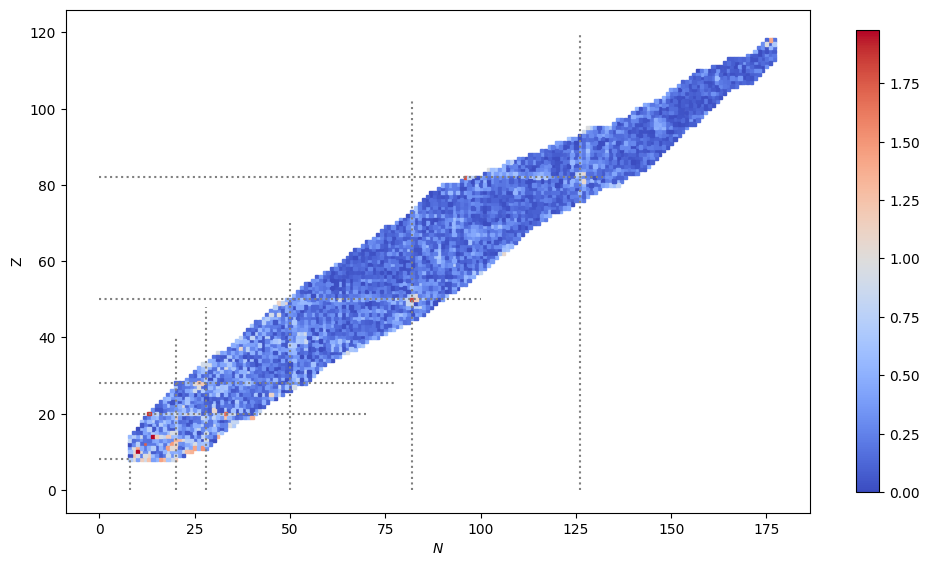

In [13]:
z_train = np.abs( list((E_train_pred-E_train).detach().numpy()) + list((E_test_pred-E_test).detach().numpy()) )
x = np.array( list(xy_train.detach().numpy()[:,1]) + list(xy_test.detach().numpy()[:,1]) )
y = np.array( list(xy_train.detach().numpy()[:,0]) + list(xy_test.detach().numpy()[:,0]) )

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(1,1,1, aspect="equal"); ax.set_xlabel("$N$"); ax.set_ylabel("Z")
wid = hei = 0.9

# prepare colors with z_train
cmap = plt.get_cmap("coolwarm")
norm = Normalize(vmin=np.min(z_train), vmax=np.max(z_train)/2)
colored_data = cmap(norm(z_train))

for idx in range(x.shape[0]):
    tx = x[idx] - wid/2
    ty = y[idx] - hei/2
    sq = patches.Rectangle((tx, ty), wid, hei, color = colored_data[idx][0][:3], fill=True)
    ax.add_patch(sq)
ax.plot( [0,8], [8,8], color="gray", ls="dotted",zorder=100)
im = ax.plot( [8,8], [0,8], color="gray", ls="dotted",zorder=100)
for magic in [20, 28, 50, 82, 126]:
    if magic == 126:
        ax.plot( [magic,magic], [0,120], color="gray", ls="dotted",zorder=100)
    else:
        ax.plot( [0,magic+50], [magic,magic], color="gray", ls="dotted",zorder=100)
        ax.plot( [magic,magic], [0,magic+20], color="gray", ls="dotted",zorder=100)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.6)
plt.show()
plt.close()

In [15]:
rms_train = (E_train-E_train_pred).pow(2).mean().sqrt()
rms_test = (E_test-E_test_pred).pow(2).mean().sqrt()

print("rms_train=", rms_train, "rms_test=", rms_test)


rms_train= tensor(0.3311, grad_fn=<SqrtBackward0>) rms_test= tensor(0.3938, grad_fn=<SqrtBackward0>)


## シンボリック回帰

KANは初等関数の組み合わせで関数を表現するシンボリック回帰が可能で、それが"解釈性が高い"という謳い文句に繋がっている。

特徴量が$(Z,N)$の2つだけのモデルを作り、訓練したモデルを、シンボリック回帰で表現してみる。

In [ ]:
model_feature = 2
subdata = extract_data_for_model(df, model_feature, item="BE(MeV)") 
dataset, mean_input, std_input, mean_label, std_label = create_dataset_AME(subdata)

model = KAN(width=[model_feature, 5, 1], grid=10, k=3)
model.fit(dataset, opt="LBFGS", steps=200);

In [ ]:
mode = "auto" # "manual"

if mode == "manual": #関数形を指定することもできる
    # 以下は例
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
    #...
elif mode == "auto":
    #lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    lib = ['x','x^2','x^{2/3}','x^{4/3}']
    model.auto_symbolic(lib=lib)

In [ ]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0],4)